In [223]:
import torch 
import numpy as numpy
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

In [224]:
torch.backends.mps.is_available()

device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


In [225]:
from sklearn.datasets import make_circles



In [226]:
X,y = make_circles(n_samples=10000, noise=0.03, random_state=42)
circles = pd.DataFrame({"X0":X[:,0],"X1":X[:,1],"label":y})

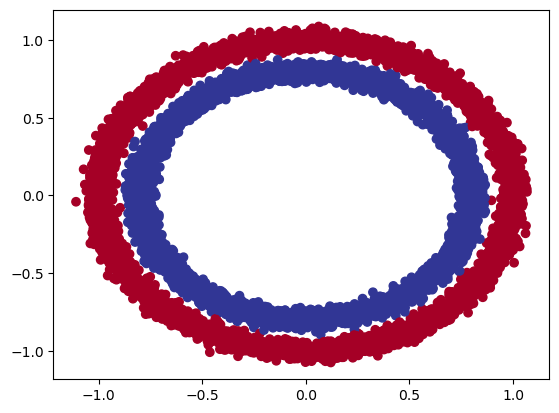

In [227]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],y=X[:,1],c=y,cmap=plt.cm.RdYlBu)

In [228]:
torch.manual_seed(42)
input = torch.tensor(X,dtype=torch.float32).to(device)
output = torch.tensor(y,dtype=torch.float32).to(device)
input.shape,output.shape



(torch.Size([10000, 2]), torch.Size([10000]))

In [229]:
from sklearn.model_selection import train_test_split
import torch.nn as nn
X_train, X_test, y_train, y_test = train_test_split(input,output, test_size=0.2, random_state=42)

In [230]:
X_train,X_test

(tensor([[ 0.2029, -1.0081],
         [-0.1717, -0.9750],
         [ 0.5565,  0.5440],
         ...,
         [-0.0074,  0.7569],
         [ 0.4034, -0.6994],
         [-0.9532,  0.2216]], device='mps:0'),
 tensor([[-0.7592,  0.2494],
         [-0.4138, -0.6322],
         [ 0.8674, -0.4740],
         ...,
         [-0.4891,  0.8601],
         [-1.0131, -0.2149],
         [-0.6978, -0.7343]], device='mps:0'))

In [231]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2,16)
        self.ReLU = nn.ReLU()
        self.layer_2 = nn.Linear(16,8)
        self.ReLU2 = nn.ReLU()
        self.layer_3 = nn.Linear(8,1)
    
    def forward(self,x):
        middle = self.ReLU(self.layer_1(x))
        middle = self.ReLU2(self.layer_2(middle))
        return self.layer_3(middle)
       

model = Model()

model.to(device)

Model(
  (layer_1): Linear(in_features=2, out_features=16, bias=True)
  (ReLU): ReLU()
  (layer_2): Linear(in_features=16, out_features=8, bias=True)
  (ReLU2): ReLU()
  (layer_3): Linear(in_features=8, out_features=1, bias=True)
)

In [232]:
model.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802],
                      [-0.3258, -0.0829],
                      [-0.2872,  0.4691],
                      [-0.5582, -0.3260],
                      [-0.1997, -0.4252],
                      [ 0.0667, -0.6984],
                      [ 0.6386, -0.6007]], device='mps:0')),
             ('layer_1.bias',
              tensor([ 0.5459,  0.1177, -0.2296,  0.4370,  0.1102,  0.5713,  0.0773, -0.2230,
                       0.1900, -0.1918,  0.2976,  0.6313,  0.4087, -0.3091,  0.4082,  0.1265],
                     device='mps:0')),
             ('laye

In [233]:
with torch.inference_mode():
    untrained_preds = model(X_test)
print(f"Length of untrained_preds: {len(untrained_preds)}")
print(f"Length of test samples: {len(X_test)}")
print(f"untrained_preds[:5]: {untrained_preds[:5]}")

Length of untrained_preds: 2000
Length of test samples: 2000
untrained_preds[:5]: tensor([[0.2308],
        [0.2379],
        [0.2907],
        [0.2756],
        [0.2284]], device='mps:0')


In [234]:
loss_fn = nn.BCEWithLogitsLoss()

optim = torch.optim.SGD(model.parameters(),lr=0.1)

In [235]:
def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_true))*100
    return acc

In [236]:
torch.manual_seed(42)
device = "mps" if torch.backends.mps.is_available() else "cpu"
epochs = 1000
model = model.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    
    model.train()
    
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # convert logits to 0 or 1
    
    optim.zero_grad()

    loss = loss_fn(y_logits,y_train)
    loss.backward()
    optim.step()
    
    model.eval()
    with torch.inference_mode():
        y_logits_test = model(X_test).squeeze()
        y_pred_test = torch.round(torch.sigmoid(y_logits_test))
        loss_test = loss_fn(y_logits_test,y_test)
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss.item():.2f} | Accuracy: {accuracy_fn(y_train,y_pred)} | Test loss: {loss_test.item():.4f} | Test accuracy: {accuracy_fn(y_test,y_pred_test):.2f}")    

Epoch: 0 | Loss: 0.70 | Accuracy: 50.1625 | Test loss: 0.7027 | Test accuracy: 49.35
Epoch: 10 | Loss: 0.70 | Accuracy: 50.1625 | Test loss: 0.6988 | Test accuracy: 49.35
Epoch: 20 | Loss: 0.70 | Accuracy: 50.1625 | Test loss: 0.6964 | Test accuracy: 49.35
Epoch: 30 | Loss: 0.69 | Accuracy: 50.1625 | Test loss: 0.6950 | Test accuracy: 49.35
Epoch: 40 | Loss: 0.69 | Accuracy: 50.1625 | Test loss: 0.6941 | Test accuracy: 49.35
Epoch: 50 | Loss: 0.69 | Accuracy: 50.1625 | Test loss: 0.6935 | Test accuracy: 49.35
Epoch: 60 | Loss: 0.69 | Accuracy: 50.1625 | Test loss: 0.6930 | Test accuracy: 49.35
Epoch: 70 | Loss: 0.69 | Accuracy: 50.1625 | Test loss: 0.6927 | Test accuracy: 49.35
Epoch: 80 | Loss: 0.69 | Accuracy: 50.1625 | Test loss: 0.6924 | Test accuracy: 49.35
Epoch: 90 | Loss: 0.69 | Accuracy: 50.824999999999996 | Test loss: 0.6921 | Test accuracy: 51.00
Epoch: 100 | Loss: 0.69 | Accuracy: 65.8375 | Test loss: 0.6919 | Test accuracy: 66.60
Epoch: 110 | Loss: 0.69 | Accuracy: 66.3625

In [237]:
from helper_functions import plot_predictions,plot_decision_boundary 

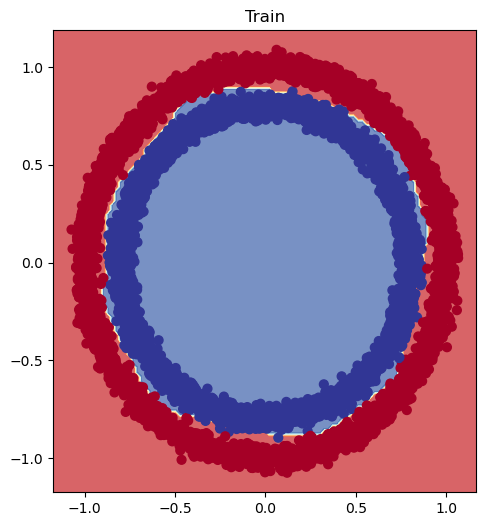

In [238]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model=model,X=X_train,y=y_train)

In [239]:
from sklearn.datasets import make_blobs
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset



X,y = make_blobs(n_samples=1000,n_features=5,random_state=42,cluster_std=5)

train_len = int(0.8*len(X))
test_len = len(X) - train_len
X= torch.tensor(X,dtype=torch.float32).to(device)
y = torch.tensor(y,dtype=torch.long).to(device)

data = TensorDataset(X,y)
train_data, test_data = random_split(data,[train_len,test_len])
data_loader = DataLoader(dataset=train_data,batch_size=32,shuffle=True)
test_loader = DataLoader(dataset=test_data,batch_size=32,shuffle=False)


In [240]:
model = nn.Sequential(nn.Linear(5,32),
                      nn.ReLU(),
                      nn.Linear(32,16),
                      nn.ReLU(),
                      nn.Linear(16,3),
                      )

In [241]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [242]:
def accuracy_fn(y_true,y_pred):
    y_pred_classes = torch.argmax(y_pred,dim=1)
    correct = torch.eq(y_true,y_pred_classes).sum().item()
    acc = (correct/len(y_true))*100
    return acc
    

In [243]:
epochs = 1000
model.compile()
model.to(device)
for epoch in range(epochs):
    model.train()
    
    for X_batch,y_batch in data_loader:
        
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss_val = loss(y_pred,y_batch.long())
        loss_val.backward()
        optimizer.step()
        
    with torch.inference_mode():
        model.eval()
        train_accuracy = accuracy_fn(y,model(X))
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Train accuracy: {train_accuracy:.2f}")
            for X_test,y_test in test_loader:
                test_accuracy = accuracy_fn(y_test,model(X_test))
                print(f"Epoch: {epoch} | Train accuracy: {train_accuracy:.2f} | Test accuracy: {test_accuracy:.2f}")
            

Epoch: 0 | Train accuracy: 88.30
Epoch: 0 | Train accuracy: 88.30 | Test accuracy: 93.75
Epoch: 0 | Train accuracy: 88.30 | Test accuracy: 84.38
Epoch: 0 | Train accuracy: 88.30 | Test accuracy: 81.25
Epoch: 0 | Train accuracy: 88.30 | Test accuracy: 90.62
Epoch: 0 | Train accuracy: 88.30 | Test accuracy: 93.75
Epoch: 0 | Train accuracy: 88.30 | Test accuracy: 93.75
Epoch: 0 | Train accuracy: 88.30 | Test accuracy: 100.00
Epoch: 10 | Train accuracy: 89.40
Epoch: 10 | Train accuracy: 89.40 | Test accuracy: 93.75
Epoch: 10 | Train accuracy: 89.40 | Test accuracy: 84.38
Epoch: 10 | Train accuracy: 89.40 | Test accuracy: 81.25
Epoch: 10 | Train accuracy: 89.40 | Test accuracy: 87.50
Epoch: 10 | Train accuracy: 89.40 | Test accuracy: 90.62
Epoch: 10 | Train accuracy: 89.40 | Test accuracy: 93.75
Epoch: 10 | Train accuracy: 89.40 | Test accuracy: 100.00
Epoch: 20 | Train accuracy: 91.20
Epoch: 20 | Train accuracy: 91.20 | Test accuracy: 90.62
Epoch: 20 | Train accuracy: 91.20 | Test accuracy

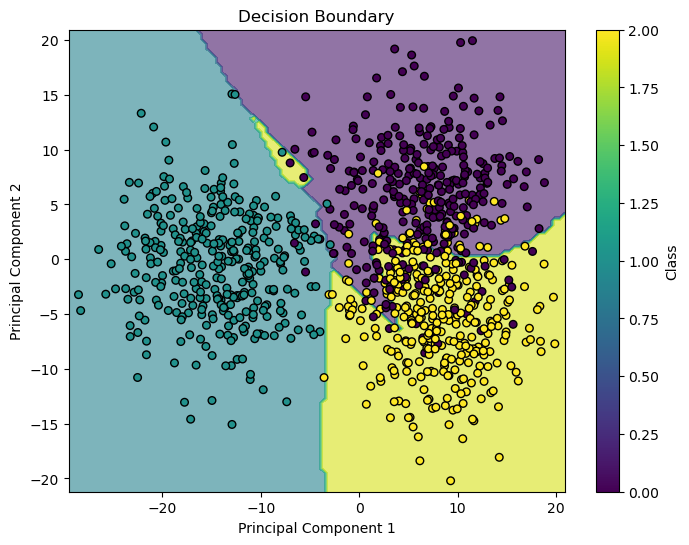

In [245]:
from sklearn.decomposition import PCA
import numpy as np
X_pca = PCA(n_components=2).fit_transform(X.cpu().detach().numpy())

# Generate 2D grid for decision boundary
xx, yy = np.meshgrid(np.linspace(X_pca[:, 0].min()-1, X_pca[:, 0].max()+1, 100),
                     np.linspace(X_pca[:, 1].min()-1, X_pca[:, 1].max()+1, 100))
grid = np.c_[xx.ravel(), yy.ravel()]

# Transform grid back to original feature space
grid_original = PCA(n_components=2).fit(X.cpu().detach().numpy()).inverse_transform(grid)
grid_tensor = torch.tensor(grid_original, dtype=torch.float32).to(device)

# Predict on the grid
model.eval()
with torch.no_grad():
    predictions = model(grid_tensor).argmax(dim=1).cpu().numpy()

# Plot decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, predictions.reshape(xx.shape), cmap='viridis', alpha=0.6)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y.cpu().numpy(), cmap='viridis', s=30, edgecolors='k')
plt.title("Decision Boundary")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Class")
plt.show()
